In [1]:
import importlib
import time
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

/home/travisharty/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [6]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)

# eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
#     dimension, dx, rho0, covariance.fft_exp_1d,
#     return_Corr=True,
#     return_sort_ind=True)

eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

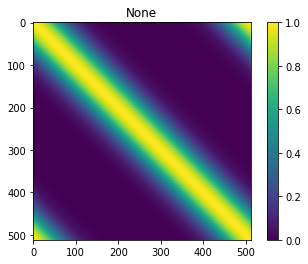

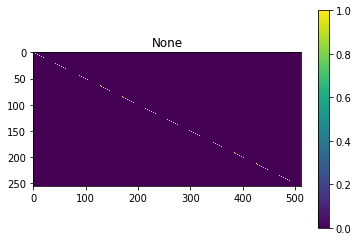

In [7]:
imshow(P, vmin=0)
imshow(H)

In [8]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


# Looking at singular values by localization

In [10]:
ens_size = 40
mu = np.zeros(dimension)
ensemble = (
    assimilate.generate_ensemble(
        ens_size, mu, trans_mats['P_sqrt']))
P_sample = np.cov(ensemble)

In [11]:
sig_max = 50
# rho_array = np.linspace(0.1, 0.4, 7)
rho_array = np.arange(0.01, .11, .01)
print(rho_array)
U_array = np.ones([rho_array.size, obs_size, sig_max])
s_array = np.ones([rho_array.size, sig_max])
V_array = np.ones([rho_array.size, dimension, sig_max])

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


/home/travisharty/anaconda3/envs/loc/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


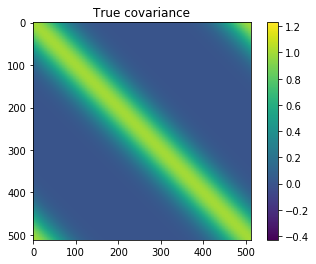

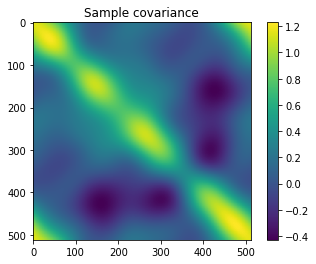

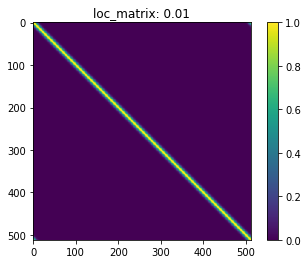

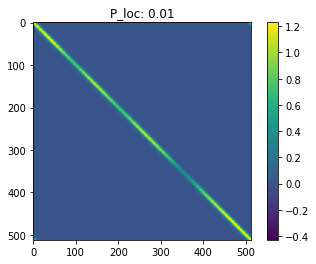

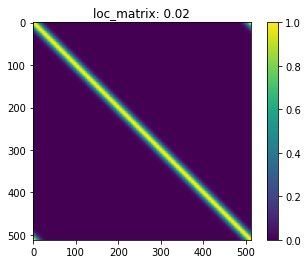

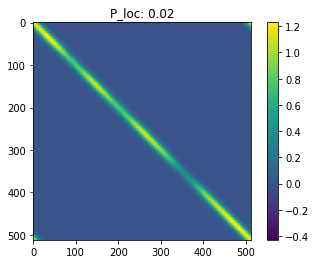

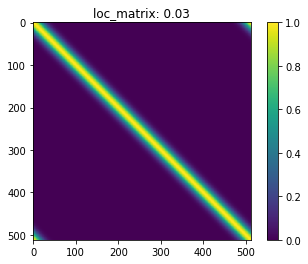

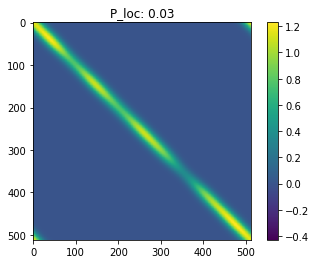

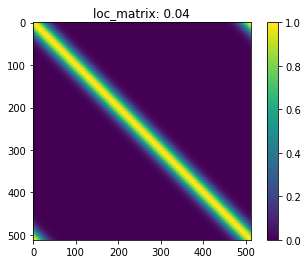

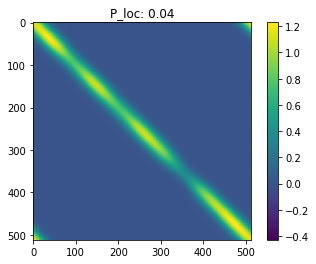

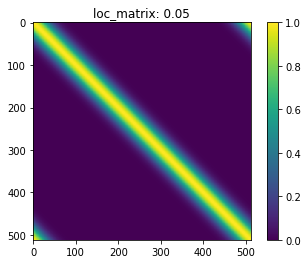

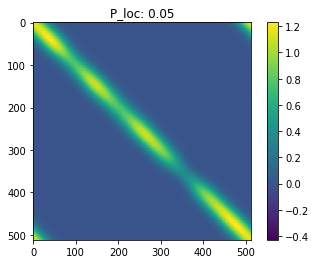

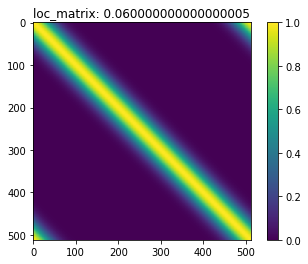

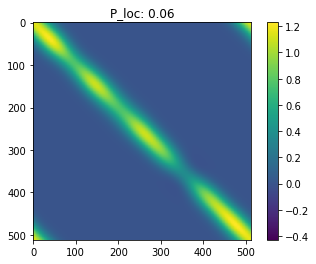

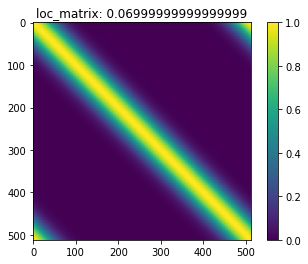

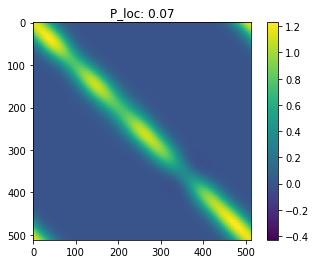

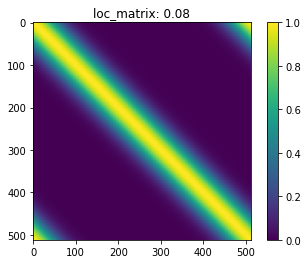

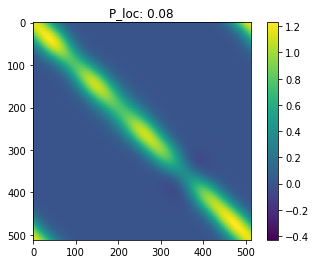

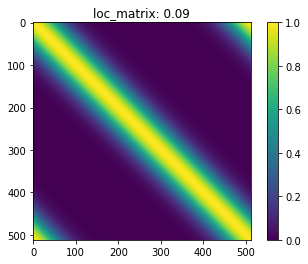

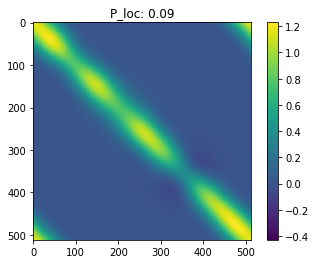

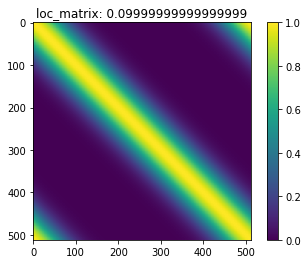

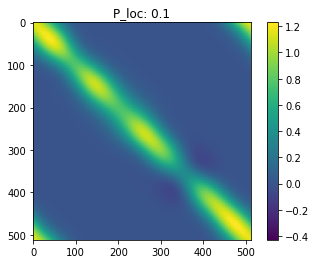

In [12]:
vmin = np.min(
    [P.min(), P_sample.min()])
vmax = np.max(
    [P.max(), P_sample.max()])
imshow(P, 'True covariance', vmin=vmin, vmax=vmax)
imshow(P_sample, 'Sample covariance',
       vmin=vmin, vmax=vmax)

for rho_loc in rho_array:
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    P_loc = P_sample * loc
    imshow(loc, f'loc_matrix: {rho_loc}', vmin=0)
    imshow(P_loc, title=f'P_loc: {np.round(rho_loc, 2)}',
           vmin=vmin, vmax=vmax)

In [13]:
for rho_count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    P_loc = P_sample * loc
    P_loc_sqrt = covariance.matrix_sqrt(P_loc).real
    aU, aS, aVT = sp.linalg.svd(H @ P_loc_sqrt)
    U_array[rho_count] = aU[:, :sig_max]
    s_array[rho_count] = aS[:sig_max]
    V_array[rho_count] = aVT[:sig_max].T

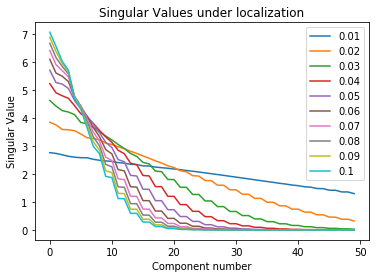

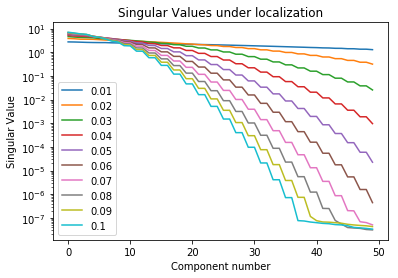

In [14]:
plt.figure()
plt.plot(s_array.T)
plt.title('Singular Values under localization')
plt.xlabel('Component number')
plt.ylabel('Singular Value')
plt.legend(np.round(rho_array, 3))


plt.figure()
plt.semilogy(s_array.T)
plt.title('Singular Values under localization')
plt.xlabel('Component number')
plt.ylabel('Singular Value')
plt.legend(np.round(rho_array, 3))

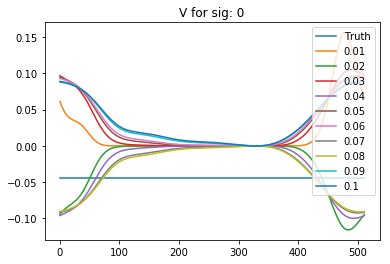

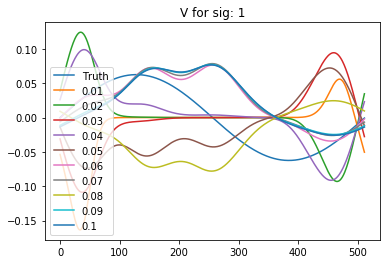

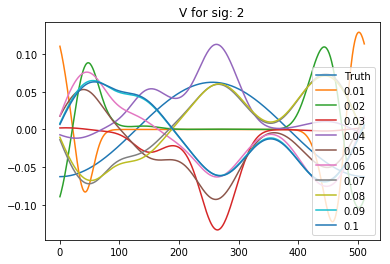

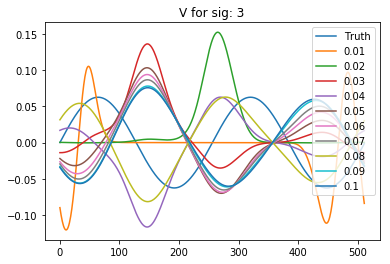

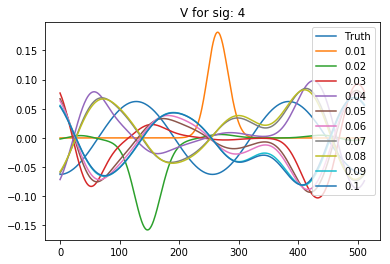

In [15]:
for ii in range(5):
    plt.figure()
    plt.plot(VT[ii])
    plt.plot(V_array[:, :, ii].T)
    plt.title(f'V for sig: {ii}')
    plt.legend(['Truth'] 
               + list(np.round(rho_array, decimals=2)))

# Looking at singular values for multiple ensembles

In [17]:
ens_size = 40
sig_max = 50
trial_num = 40
sig_vals = np.ones([trial_num, sig_max]) * np.nan
mu = np.zeros(dimension)
for ii in range(trial_num):
    ensemble = (
        assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt']))
    P_sample = np.cov(ensemble)
    aU, aS, aVT = sp.linalg.svd(H @ P_sample)
    sig_vals[ii] = aS[:sig_max]

In [27]:
sig_vals.sum(axis=1)

40

Text(0,0.5,'Singular Value')

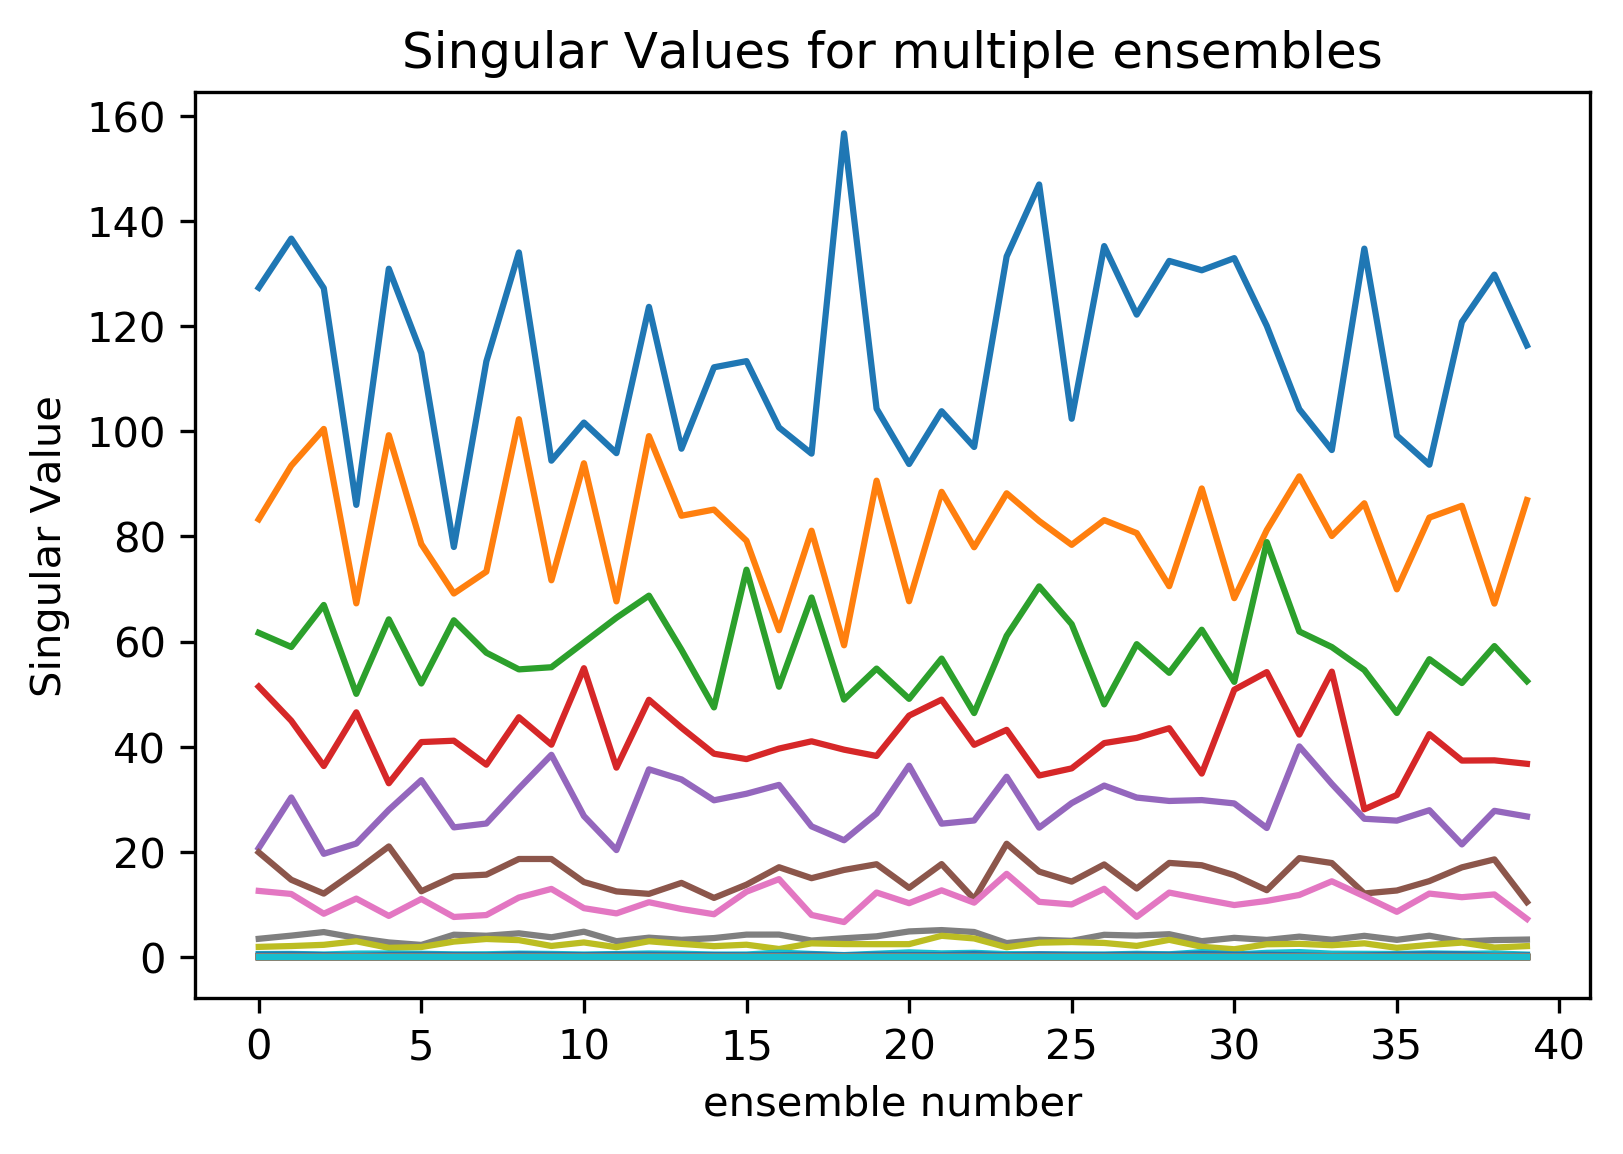

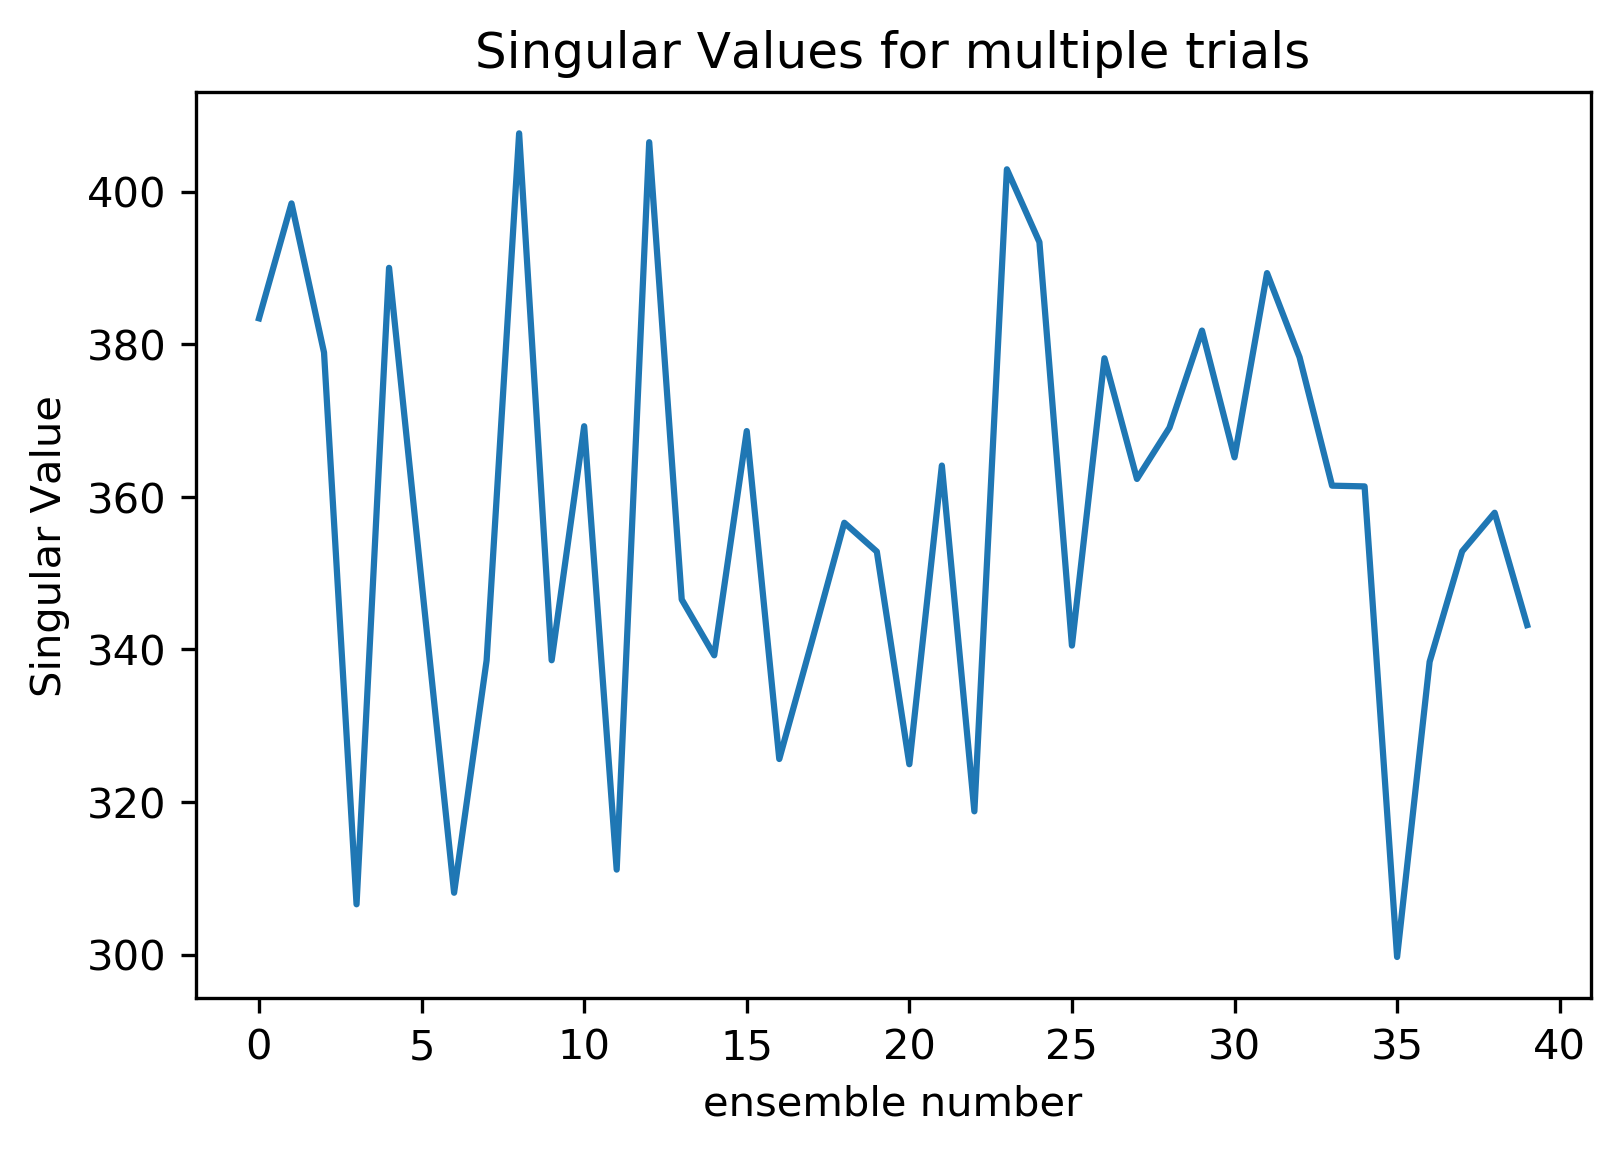

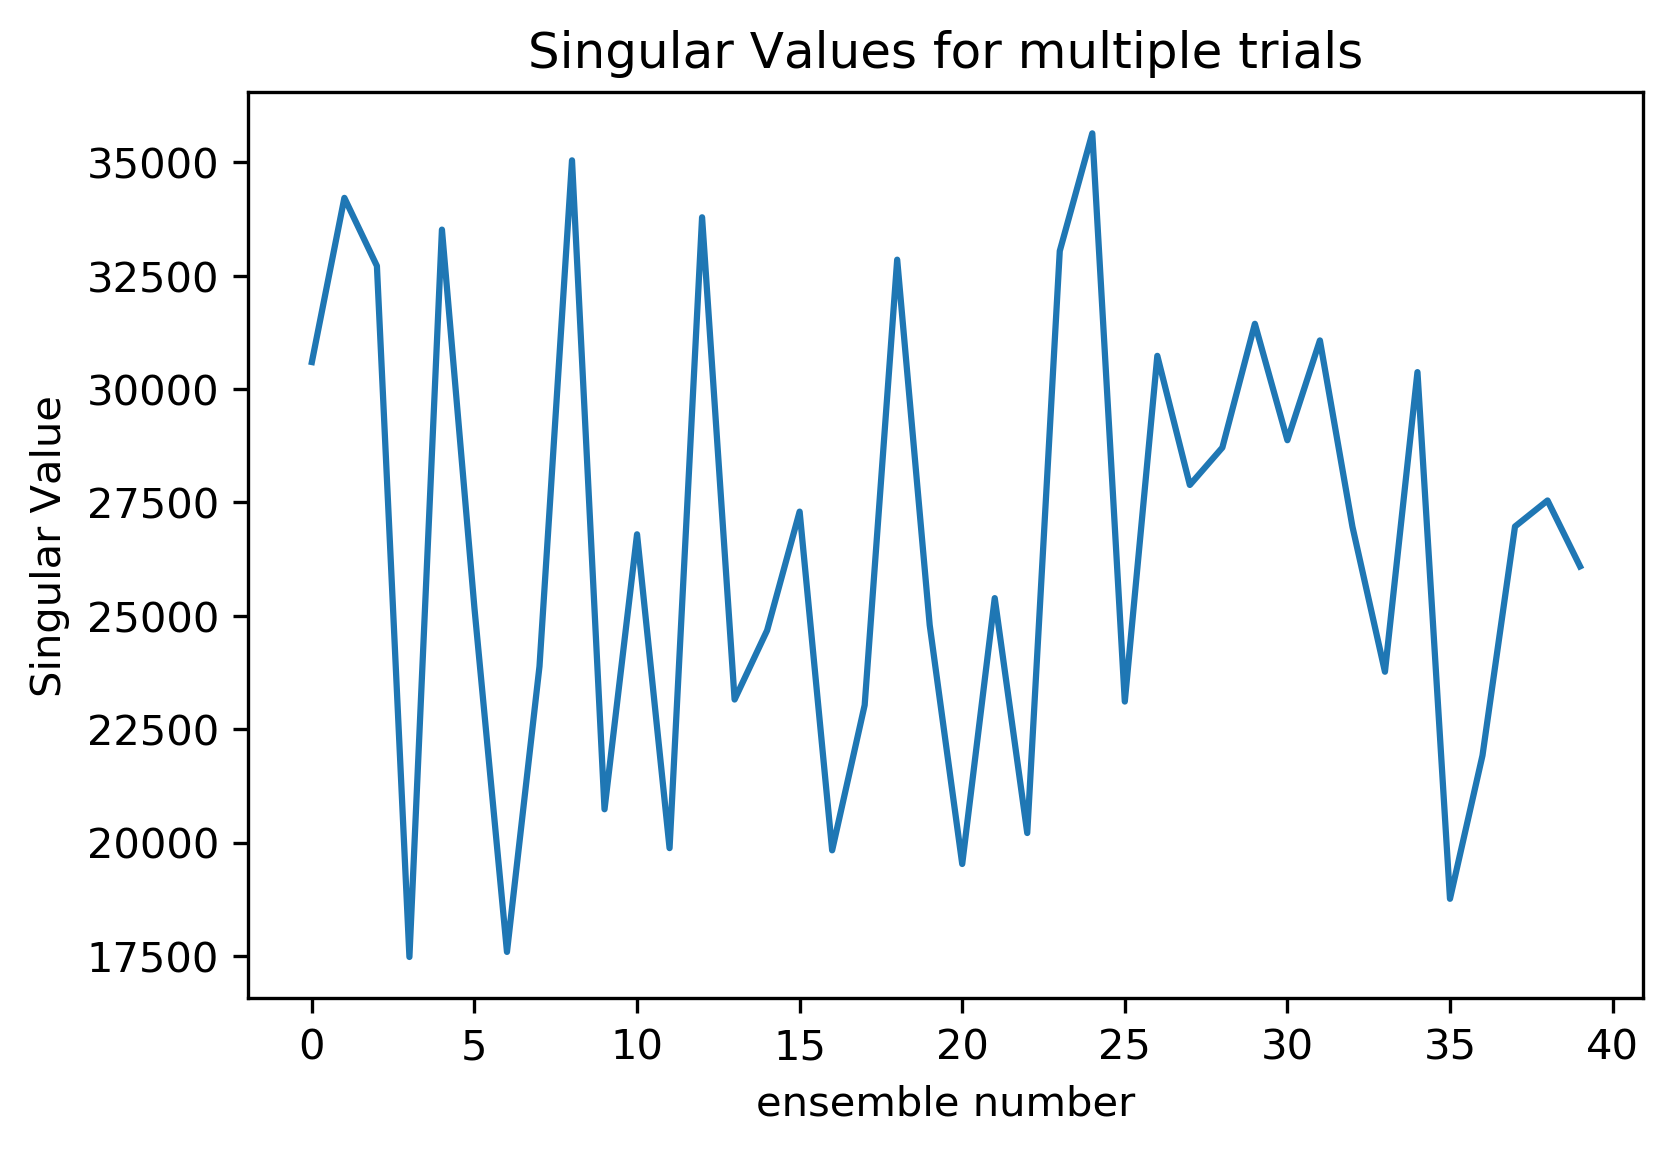

In [28]:
plt.figure(dpi=300)
plt.plot(sig_vals)
plt.title('Singular Values for multiple ensembles')
plt.xlabel('ensemble number')
plt.ylabel('Singular Value')

plt.figure(dpi=300)
plt.plot(sig_vals.sum(axis=1))
plt.title('Singular Values for multiple trials')
plt.xlabel('ensemble number')
plt.ylabel('Singular Value')

plt.figure(dpi=300)
plt.plot((sig_vals**2).sum(axis=1))
plt.title('Singular Values for multiple trials')
plt.xlabel('ensemble number')
plt.ylabel('Singular Value')

In [11]:
sig_max = 50
# rho_array = np.linspace(0.1, 0.4, 7)
rho_array = np.arange(0.01, .11, .01)
print(rho_array)
U_array = np.ones([rho_array.size, obs_size, sig_max])
s_array = np.ones([rho_array.size, sig_max])
V_array = np.ones([rho_array.size, dimension, sig_max])

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


/home/travisharty/anaconda3/envs/loc/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


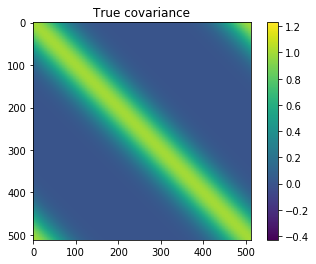

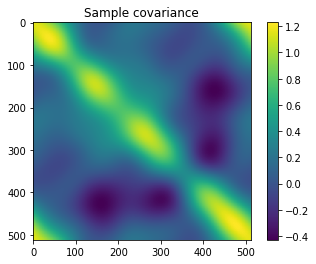

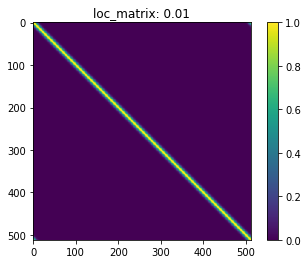

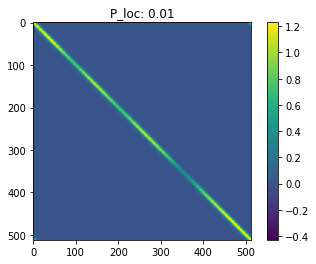

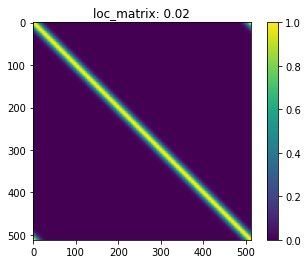

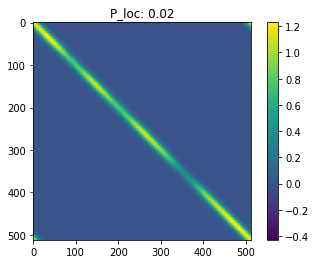

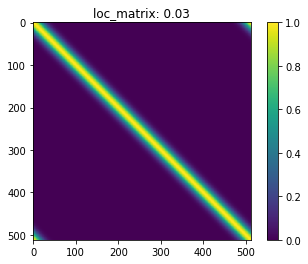

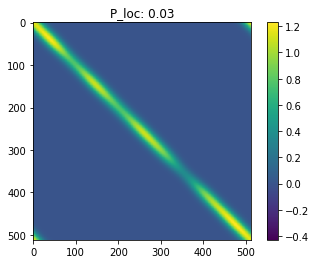

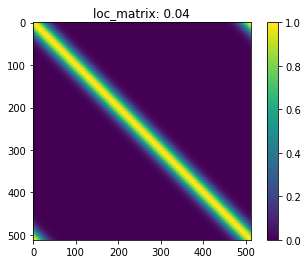

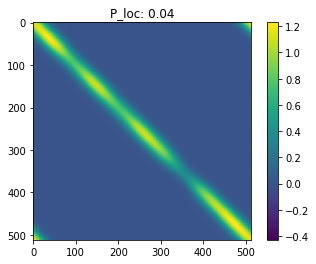

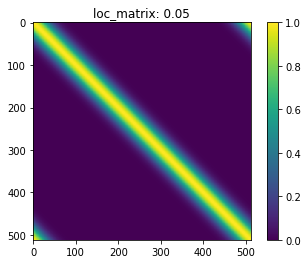

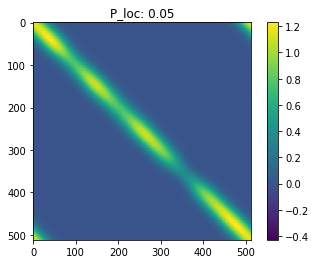

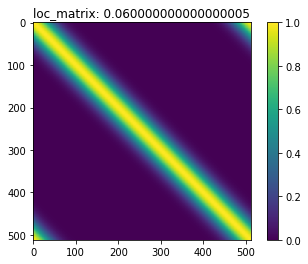

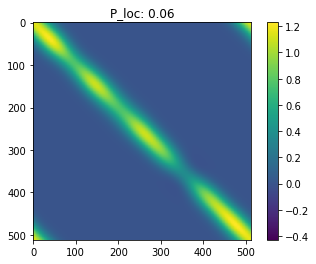

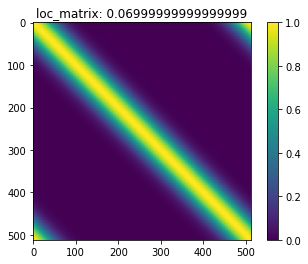

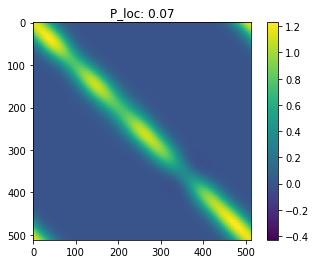

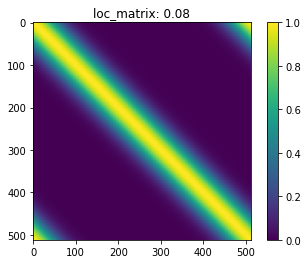

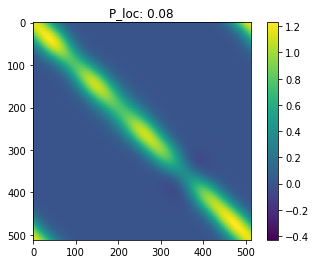

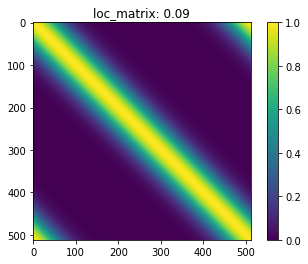

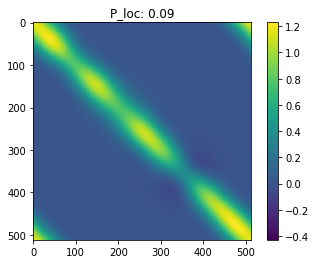

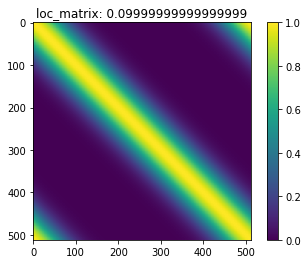

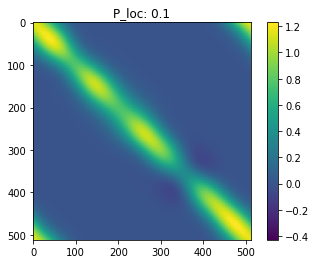

In [12]:
vmin = np.min(
    [P.min(), P_sample.min()])
vmax = np.max(
    [P.max(), P_sample.max()])
imshow(P, 'True covariance', vmin=vmin, vmax=vmax)
imshow(P_sample, 'Sample covariance',
       vmin=vmin, vmax=vmax)

for rho_loc in rho_array:
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    P_loc = P_sample * loc
    imshow(loc, f'loc_matrix: {rho_loc}', vmin=0)
    imshow(P_loc, title=f'P_loc: {np.round(rho_loc, 2)}',
           vmin=vmin, vmax=vmax)

In [13]:
for rho_count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    P_loc = P_sample * loc
    P_loc_sqrt = covariance.matrix_sqrt(P_loc).real
    aU, aS, aVT = sp.linalg.svd(H @ P_loc_sqrt)
    U_array[rho_count] = aU[:, :sig_max]
    s_array[rho_count] = aS[:sig_max]
    V_array[rho_count] = aVT[:sig_max].T

In [16]:
sig_slice.stop

NameError: name 'sig_slice' is not defined


slice(0, 1, None)

slice(1, 3, None)

slice(3, 5, None)

slice(5, 7, None)

slice(7, 9, None)


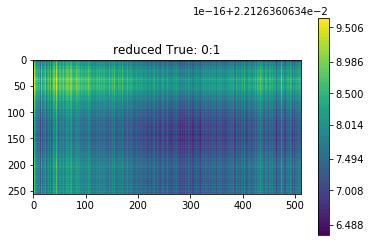

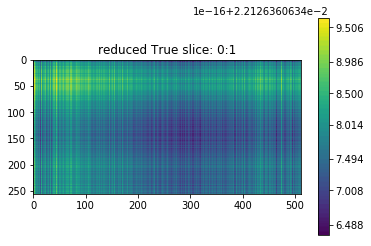

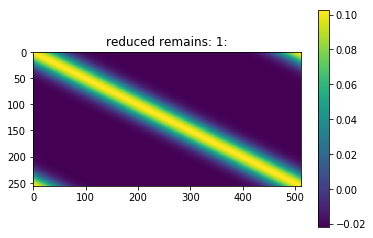

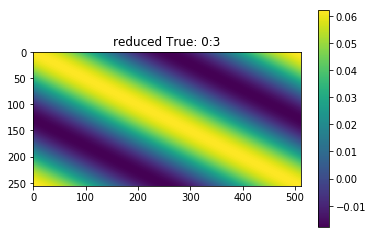

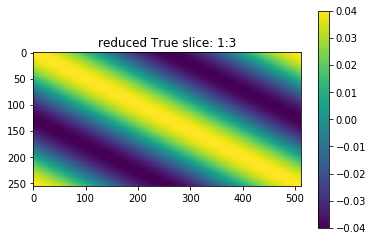

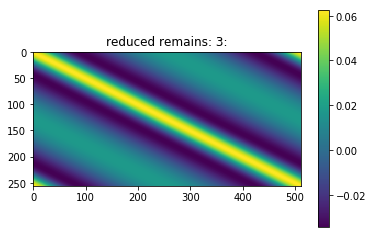

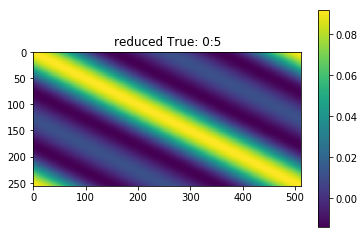

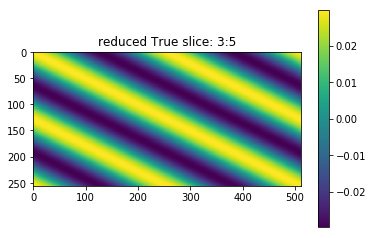

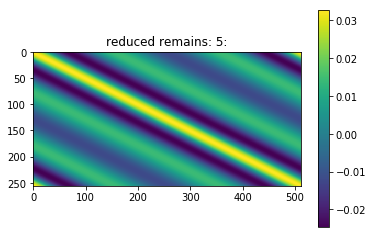

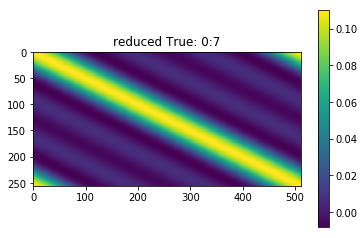

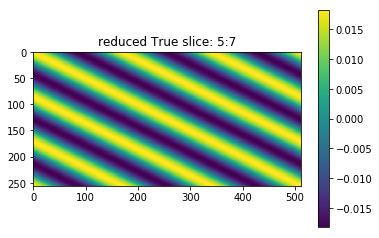

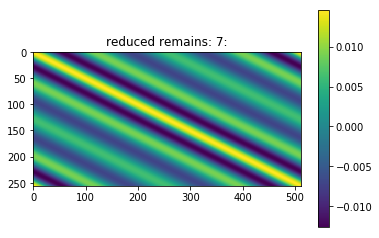

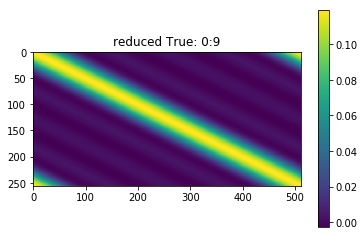

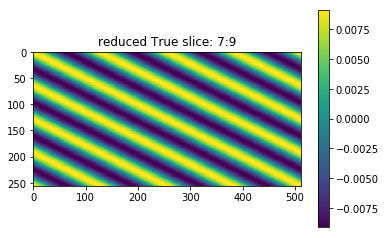

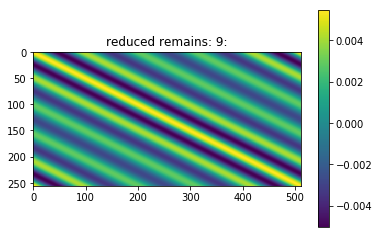

In [58]:
sig_array = np.concatenate(
    [[1], np.repeat([2], 4)])
last_sig = 0

for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print('')
    print(sig_slice)
    last_sig = last_sig + sig_num
    
    true_reduced = (
        U[:, :last_sig]
        @ S[:last_sig, :last_sig]
        @ VT[:last_sig])
    
    true_reduced_slice = (
        U[:, sig_slice]
        @ S[sig_slice, sig_slice]
        @ VT[sig_slice])
    
    true_remains = (
        U[:, last_sig:]
        @ S[last_sig:, last_sig:]
        @ VT[last_sig:])

    imshow(true_reduced,
           title=f'reduced True: 0:{sig_slice.stop}',
           )
    
    imshow(true_reduced_slice,
           title=f'reduced True slice: {sig_slice.start}:{sig_slice.stop}',
           )
    
    imshow(true_remains,
           title=f'reduced remains: {sig_slice.stop}:',
           )


slice(0, 1, None)

slice(1, 2, None)

slice(2, 3, None)

slice(3, 4, None)

slice(4, 5, None)


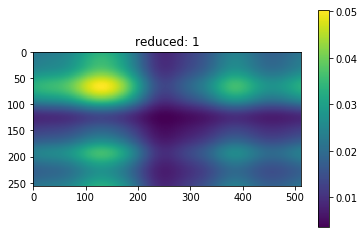

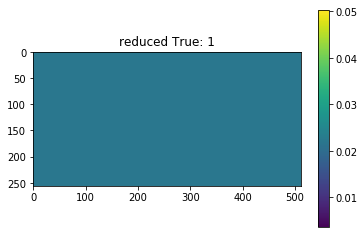

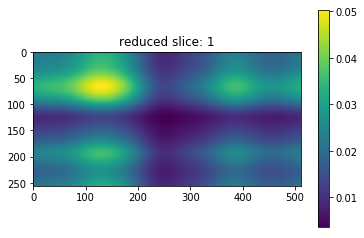

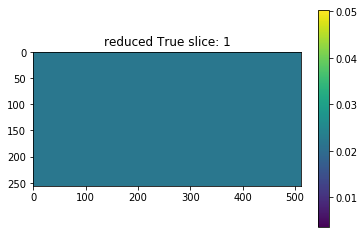

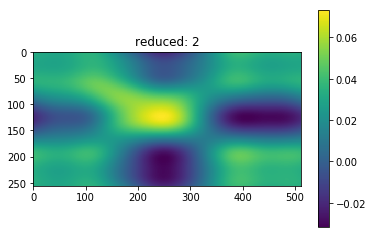

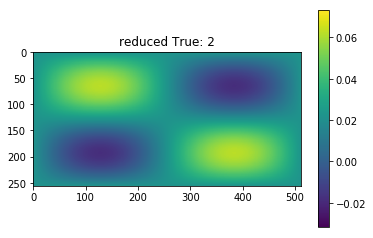

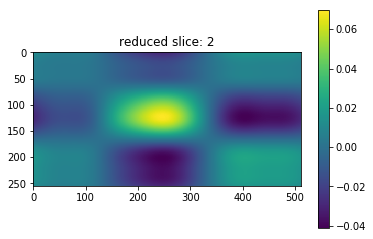

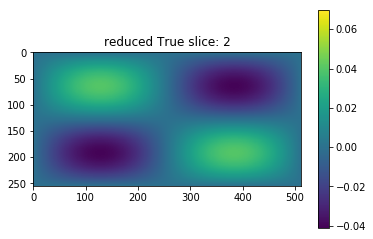

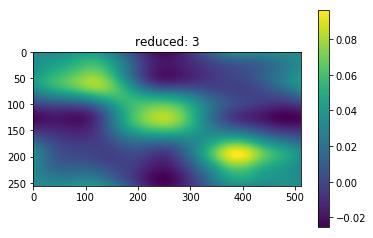

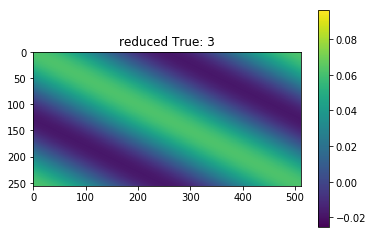

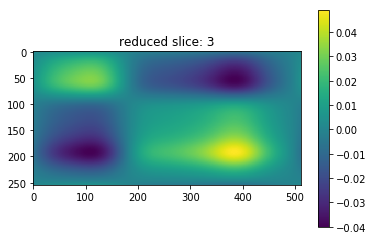

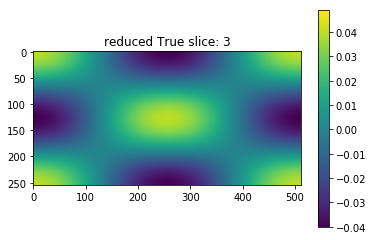

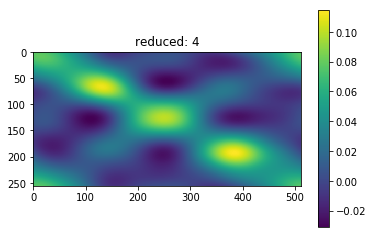

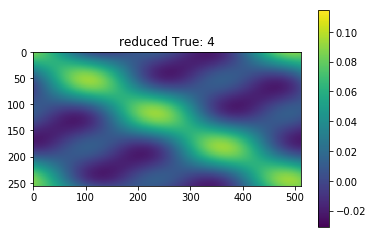

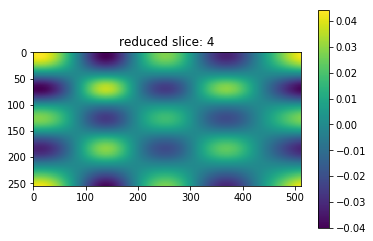

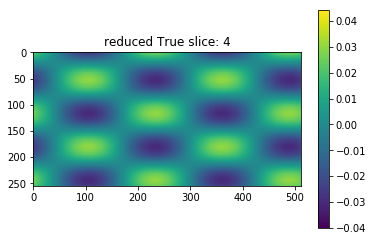

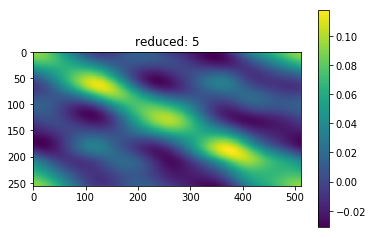

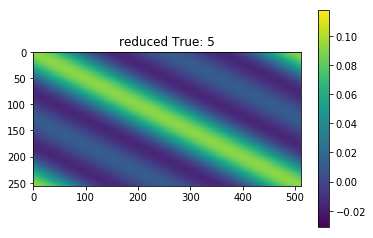

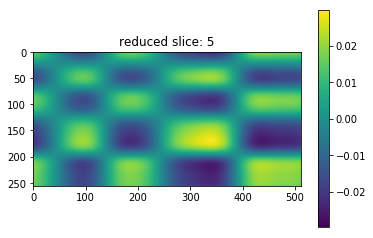

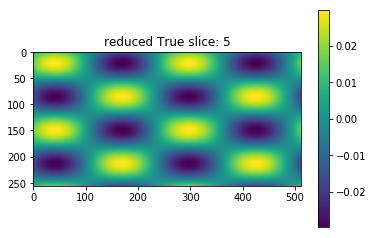

In [50]:
sig_array = np.concatenate(
    [[3], np.repeat([4], 3)])
sig_array = np.repeat([1], 5)
# sig_array = np.concatenate(
#     [[0], [3], np.repeat([4], 3)])
# sig_array = np.array([19])
last_sig = 0
opt_reduced = np.zeros([obs_size, dimension])
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print('')
    print(sig_slice)
    last_sig = last_sig + sig_num
    opt_reduced_slice = (
        U_array[-1 - sig_count, :, sig_slice]
        @ np.diag(s_array[-1 - sig_count, sig_slice])
        @ V_array[-1 - sig_count, :, sig_slice].T)
    opt_reduced += opt_reduced_slice
    true_reduced = (
        U[:, :last_sig]
        @ S[:last_sig, :last_sig]
        @ VT[:last_sig])
    true_reduced_slice = (
        U[:, sig_slice]
        @ S[sig_slice, sig_slice]
        @ VT[sig_slice])
#     this_V = V_array[-1 - sig_count, :, :last_sig]
#     Proj = np.eye(dimension) - thi
    vmin = np.min([
        opt_reduced.min(),
        true_reduced.min()
    ])
    vmax = np.max([
        opt_reduced.max(),
        true_reduced.max()
    ])
    imshow(opt_reduced,
           title=f'reduced: {last_sig}',
           vmin=vmin,
           vmax=vmax)
    imshow(true_reduced,
           title=f'reduced True: {last_sig}',
           vmin=vmin,
           vmax=vmax)
    
    vmin = np.min([
        opt_reduced_slice.min(),
        true_reduced_slice.min()
    ])
    vmax = np.max([
        opt_reduced_slice.max(),
        true_reduced_slice.max()
    ])
    imshow(opt_reduced_slice,
           title=f'reduced slice: {last_sig}',
           vmin=vmin,
           vmax=vmax)
    
    imshow(true_reduced_slice,
           title=f'reduced True slice: {last_sig}',
           vmin=vmin,
           vmax=vmax)


slice(0, 1, None)

slice(1, 3, None)

slice(3, 5, None)


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



slice(5, 7, None)

slice(7, 9, None)

slice(9, 11, None)


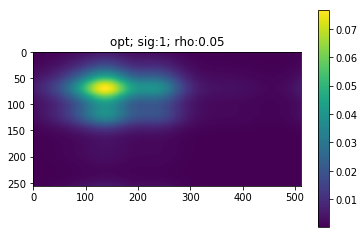

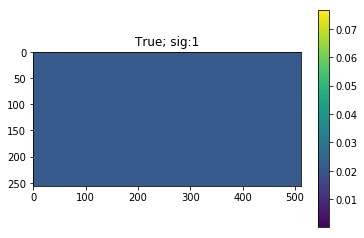

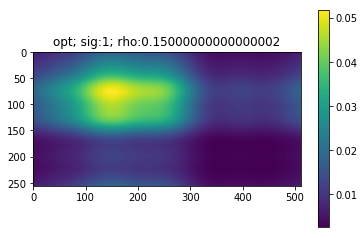

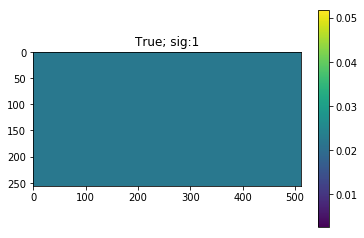

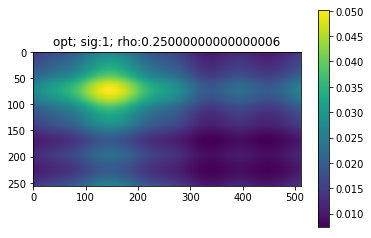

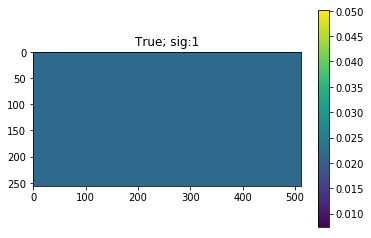

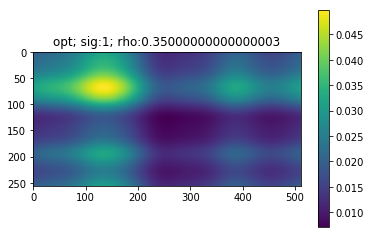

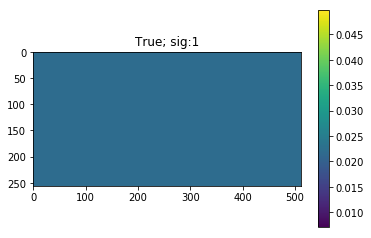

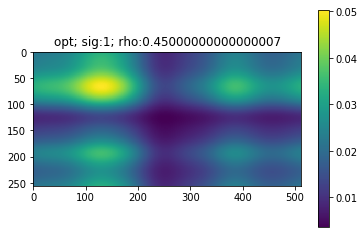

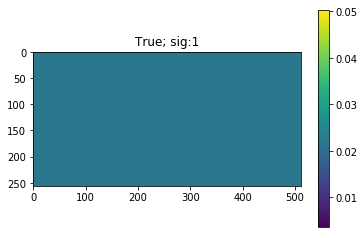

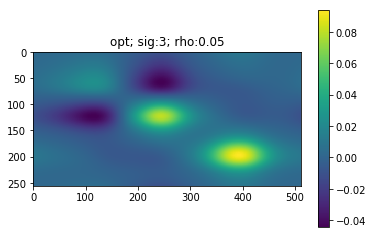

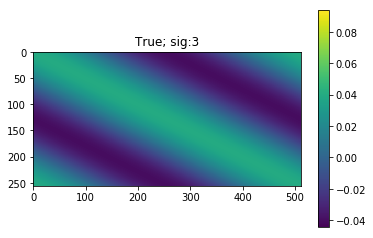

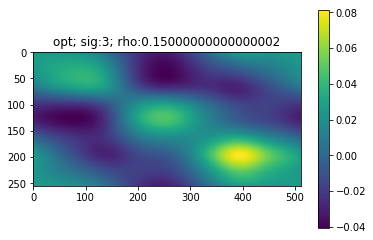

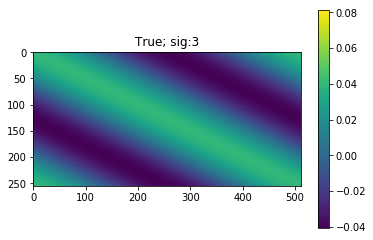

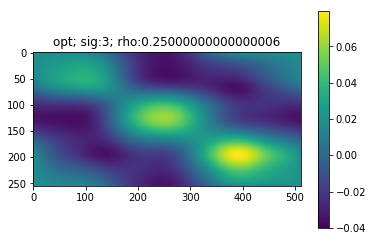

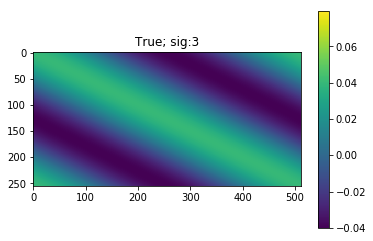

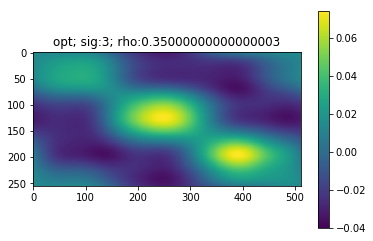

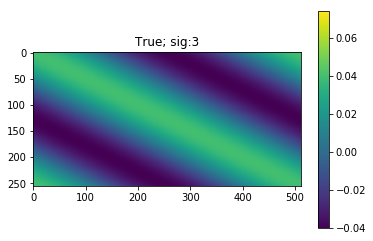

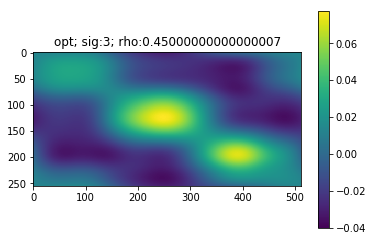

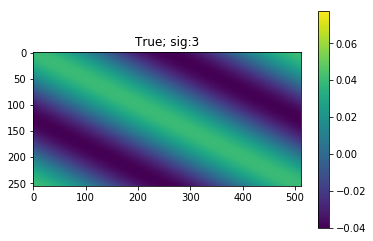

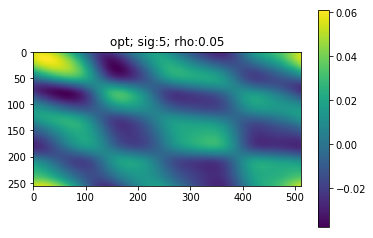

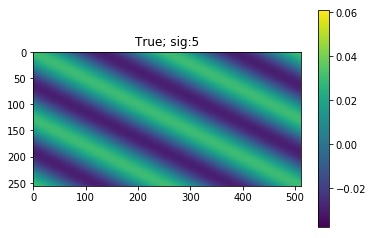

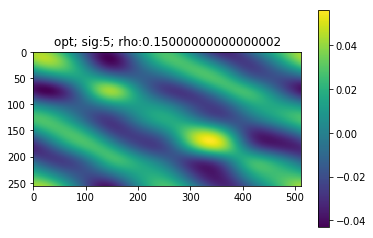

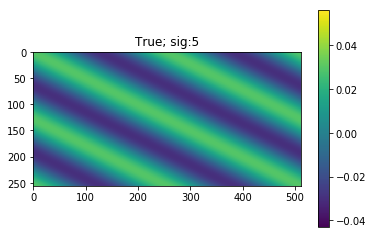

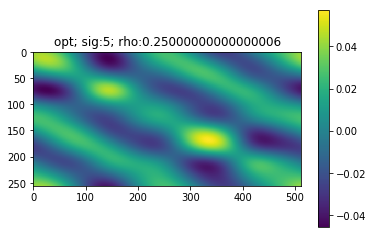

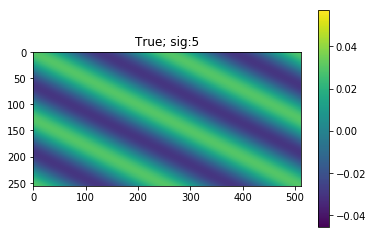

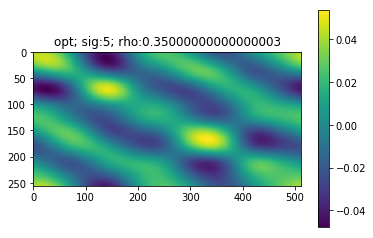

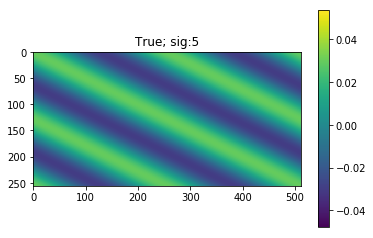

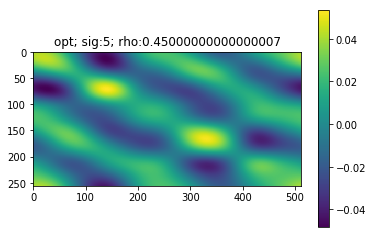

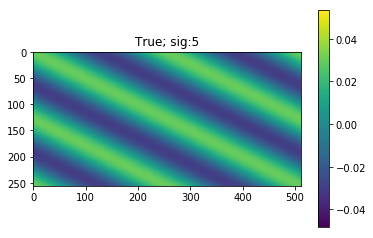

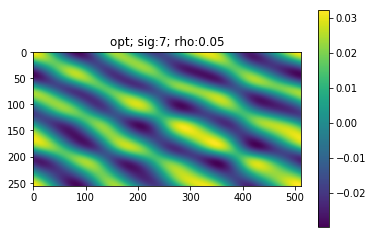

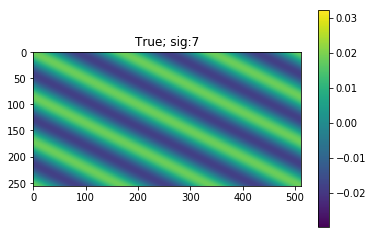

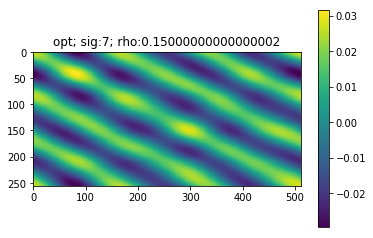

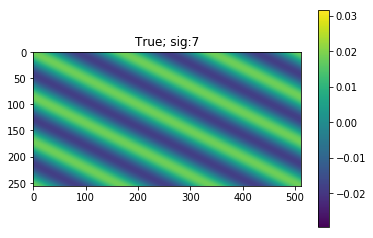

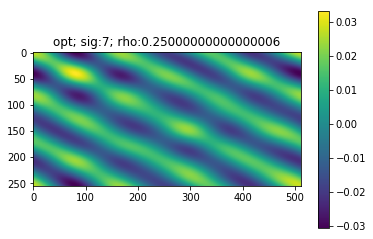

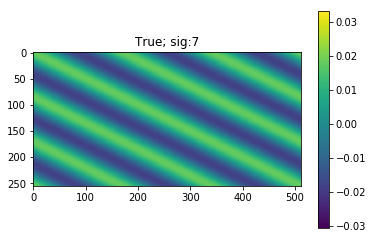

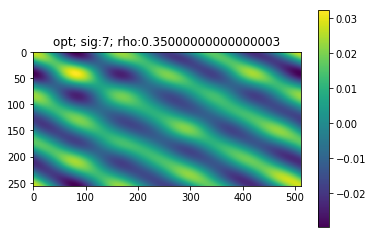

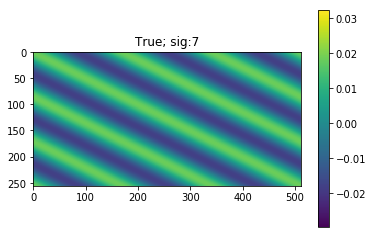

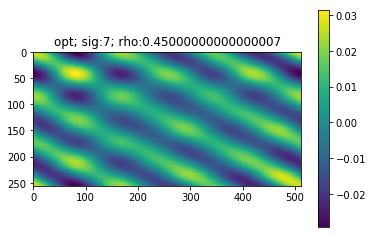

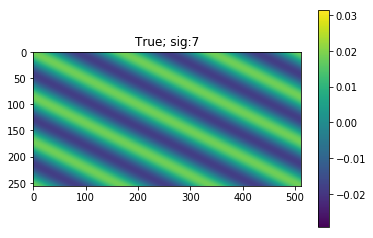

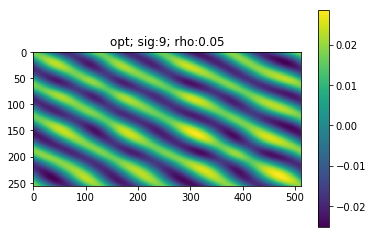

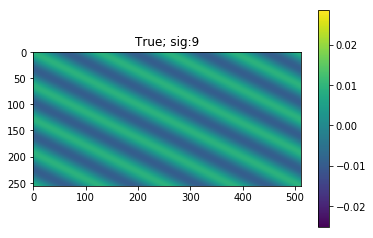

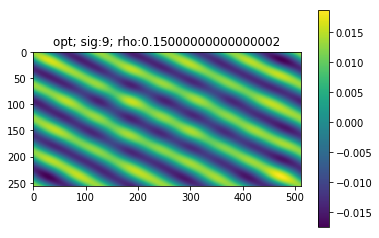

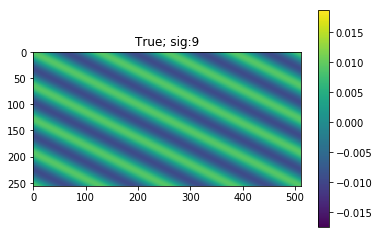

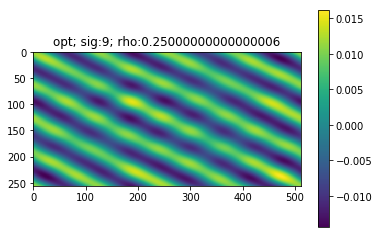

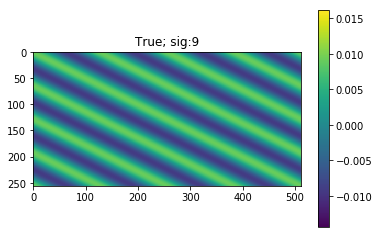

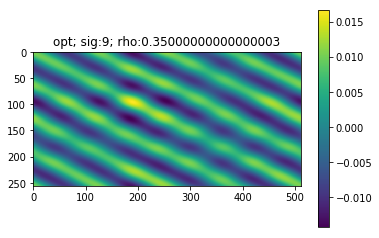

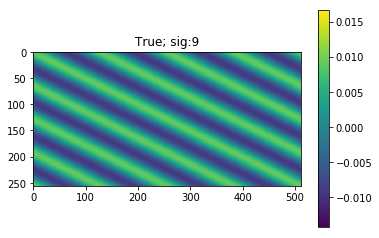

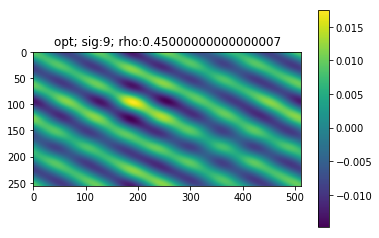

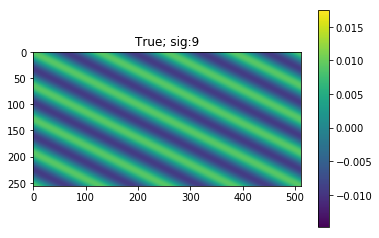

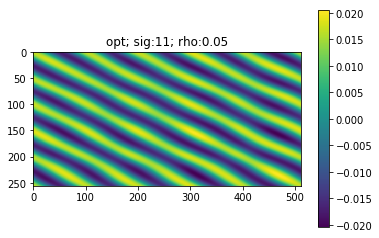

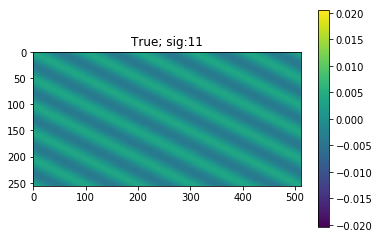

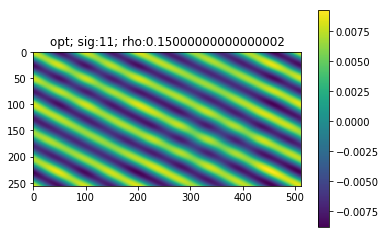

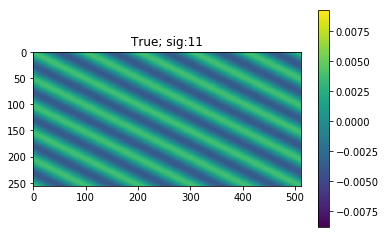

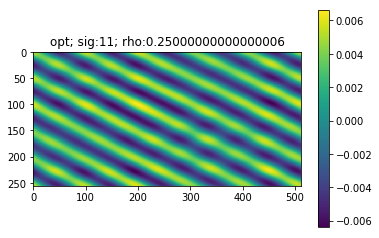

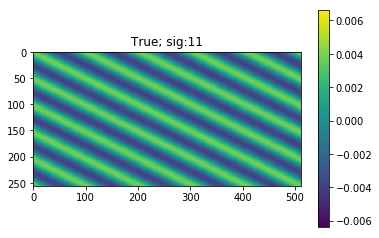

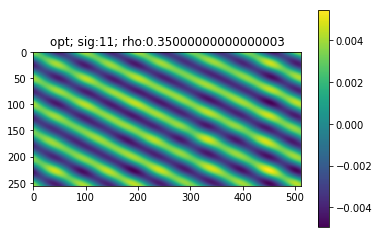

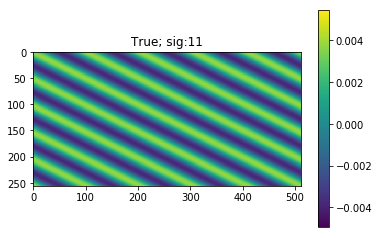

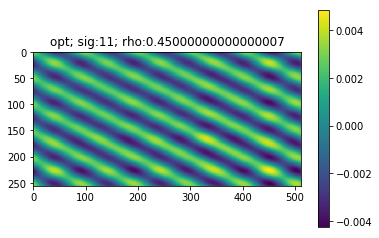

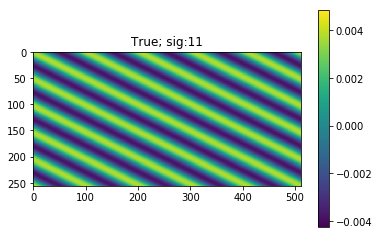

In [47]:
sig_array = np.concatenate(
    [[1], np.repeat([2], 5)])
last_sig = 0
opt_reduced = np.zeros([obs_size, dimension])
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print('')
    print(sig_slice)
    last_sig = last_sig + sig_num
    true_reduced = (
        U[:, :last_sig]
        @ S[:last_sig, :last_sig]
        @ VT[:last_sig])
    true_reduced_slice = (
        U[:, sig_slice]
        @ S[sig_slice, sig_slice]
        @ VT[sig_slice])
    for rho_count, loc_rho in enumerate(rho_array):
        opt_reduced_slice = (
            U_array[rho_count, :, sig_slice]
            @ np.diag(s_array[rho_count, sig_slice])
            @ V_array[rho_count, :, sig_slice].T)
        opt_reduced += opt_reduced_slice

#         vmin = np.min([
#             opt_reduced.min(),
#             true_reduced.min()
#         ])
#         vmax = np.max([
#             opt_reduced.max(),
#             true_reduced.max()
#         ])
#         imshow(opt_reduced,
#                title=f'reduced: {last_sig}',
#                vmin=vmin,
#                vmax=vmax)
#         imshow(true_reduced,
#                title=f'reduced True: {last_sig}',
#                vmin=vmin,
#                vmax=vmax)

        vmin = np.min([
            opt_reduced_slice.min(),
            true_reduced_slice.min()
        ])
        vmax = np.max([
            opt_reduced_slice.max(),
            true_reduced_slice.max()
        ])
        imshow(opt_reduced_slice,
               title=f'opt; sig:{last_sig}; rho:{loc_rho}',
               vmin=vmin,
               vmax=vmax)

        imshow(true_reduced_slice,
               title=f'True; sig:{last_sig}',
               vmin=vmin,
               vmax=vmax)